In [106]:
### Check GPU
!nvidia-smi
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Thu Mar  6 13:09:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             33W /   70W |     388MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [107]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is now enabled!")
    except RuntimeError as e:
        print("Error setting GPU:", e)
else:
    print("No GPU available. Using CPU instead.")

GPU is now enabled!


In [108]:
# Import libraries
import os
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional

from transformers import BertTokenizer, TFBertForSequenceClassification

import warnings
warnings.filterwarnings("ignore")

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [110]:
# Download  NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [111]:
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, f1_score

 ## 1. Brief description of the problem and data

**Description:**

This project aims to develop a deep learning model to classify tweets as real disaster-related or not. Using a dataset of 10,000 hand-labeled tweets, the goal is to enhance automated disaster detection for emergency response and news agencies. This serves as an excellent introduction to NLP, leveraging deep learning techniques for text classification. The methodology will include the following stages:

- Brief Description of the Problem and Data
- Exploratory Data Analysis (EDA)
- Model Architecture and Development
- Results and Analysis
- Conclusion

**Data:**

The dataset consists of tweets labeled as disaster-related (1) or not (0). It includes:

- train.csv : Labeled tweets for training
- test.csv : Unlabeled tweets for prediction
- sample_submission.csv : Example format for submission

Each tweet contains id, text, location, keyword and target fields.

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [112]:
dir = "/content/drive/My Drive/DTSA5511/Week4/nlp-getting-started/"
train_file = dir + "train.csv"
test_file = dir + "test.csv"

train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

In [113]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [114]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [115]:
# Check dataset structure
train.info(),
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


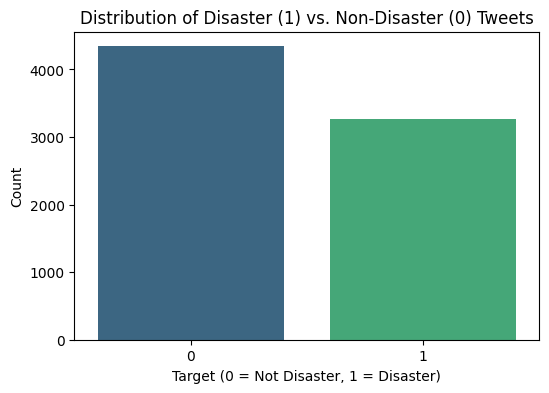

,count
target,
0,4342
1,3271


In [116]:
# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=train["target"], palette="viridis")
plt.title("Distribution of Disaster (1) vs. Non-Disaster (0) Tweets")
plt.xlabel("Target (0 = Not Disaster, 1 = Disaster)")
plt.ylabel("Count")
plt.show()

train["target"].value_counts()

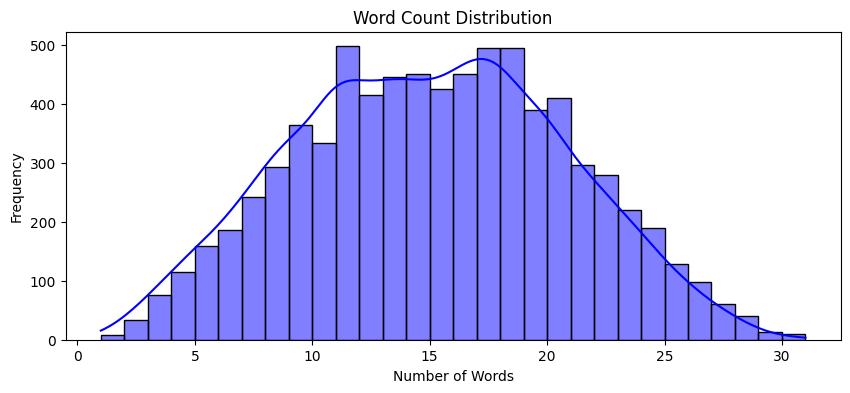

In [117]:
#  Peroform text length analysis and add columns for text it
train["word_count"] = train["text"].apply(lambda x: len(x.split()))
train["char_count"] = train["text"].apply(lambda x: len(x))

# Plot word count distribution
plt.figure(figsize=(10,4))
sns.histplot(train["word_count"], bins=30, kde=True, color="blue")
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

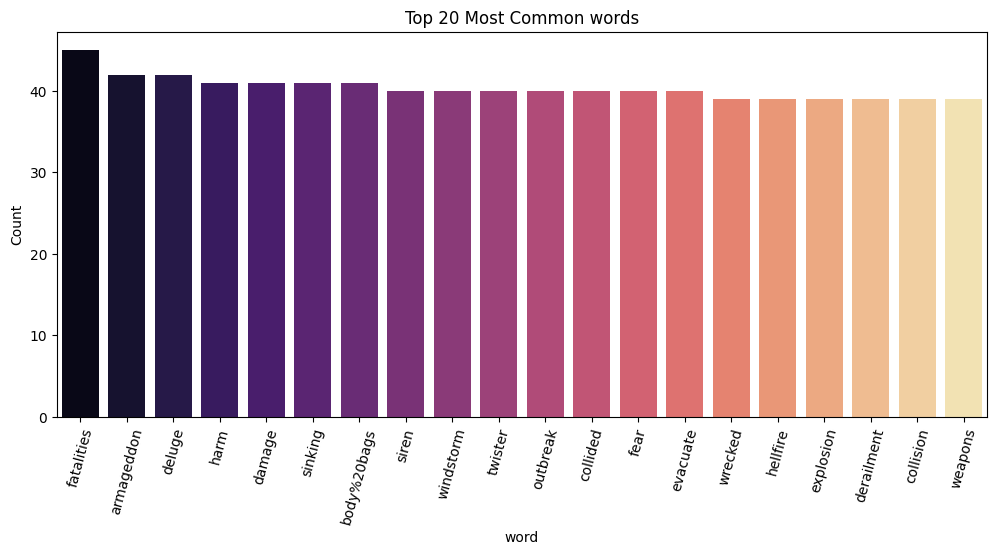

In [118]:
# Most Common Keywords top 20
keyword_counts = train["keyword"].value_counts().nlargest(20)

plt.figure(figsize=(12,5))
sns.barplot(x=keyword_counts.index, y=keyword_counts.values, palette="magma")
plt.xticks(rotation=75)
plt.title("Top 20 Most Common words")
plt.xlabel("word")
plt.ylabel("Count")
plt.show()

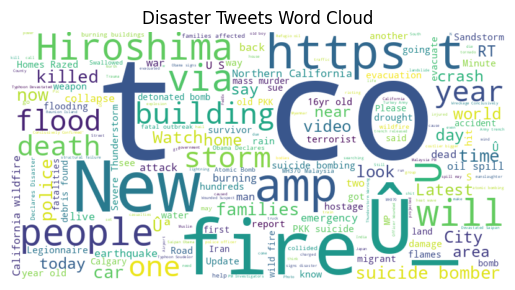

In [119]:
# Disaster tweets
disaster_text = " ".join(train[train["target"]==1]["text"])
wordcloud_disaster = WordCloud(width=800, height=400, background_color="white").generate(disaster_text)

plt.imshow(wordcloud_disaster, interpolation="bilinear")
plt.axis("off")
plt.title("Disaster Tweets Word Cloud")

plt.show()

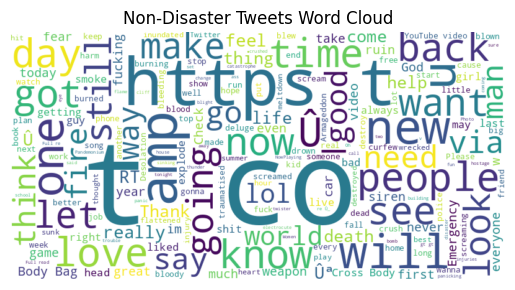

In [120]:
# Non-disaster tweets
non_disaster_text = " ".join(train[train["target"]==0]["text"])
wordcloud_nondisaster = WordCloud(width=800, height=400, background_color="white").generate(non_disaster_text)

plt.imshow(wordcloud_nondisaster, interpolation="bilinear")
plt.axis("off")
plt.title("Non-Disaster Tweets Word Cloud")
plt.show()

In [121]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    tokens = word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(cleaned_tokens)

In [122]:
train["clean_text"] = train["text"].apply(clean_text)
test["clean_text"] = test["text"].apply(clean_text)

train[["text", "clean_text"]].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...


### 3. Model Architecture and Development

Begin with simple RNN model

In [123]:
# Hyper parameters
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

In [124]:
# Tokenize and pad text data
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train["clean_text"])

In [125]:
X_train = tokenizer.texts_to_sequences(train["clean_text"])
X_test = tokenizer.texts_to_sequences(test["clean_text"])

In [126]:
# Apply padding to ensure uniform length
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding="post")

In [127]:
y_train = train["target"]

In [128]:
# Split data
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [129]:
# Basedline RNN model
rnn_model = Sequential([
    Embedding(input_dim=MAX_WORDS+1, output_dim=50, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    SimpleRNN(32, activation="tanh"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

In [130]:
# Compile model
rnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [131]:
rnn_model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

In [132]:
# Display model summary
rnn_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 100, 50)             │         500,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_7                  │ (None, 100, 50)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 32)                  │           2,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 502,739 (1.92 MB)

 Trainable params: 502,739 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
history = rnn_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5427 - loss: 0.6917 - val_accuracy: 0.5706 - val_loss: 0.6816
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5804 - loss: 0.6760 - val_accuracy: 0.5706 - val_loss: 0.6873
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6162 - loss: 0.6566 - val_accuracy: 0.5995 - val_loss: 0.6746
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7491 - loss: 0.5497 - val_accuracy: 0.6139 - val_loss: 0.7134
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8186 - loss: 0.4534 - val_accuracy: 0.6349 - val_loss: 0.7219
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8672 - loss: 0.3744 - val_accuracy: 0.6238 - val_loss: 0.8307
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8955 - loss: 0.3052 - val_accuracy: 0.6185 - val_loss: 0.9220
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9163 - loss: 0.2576 - val_accuracy

In [134]:
y_val_pred = (rnn_model.predict(X_val) > 0.5).astype("int32")

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1_score = f1_score(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1_score:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Validation Accuracy: 0.6060
Validation F1 Score: 0.5455


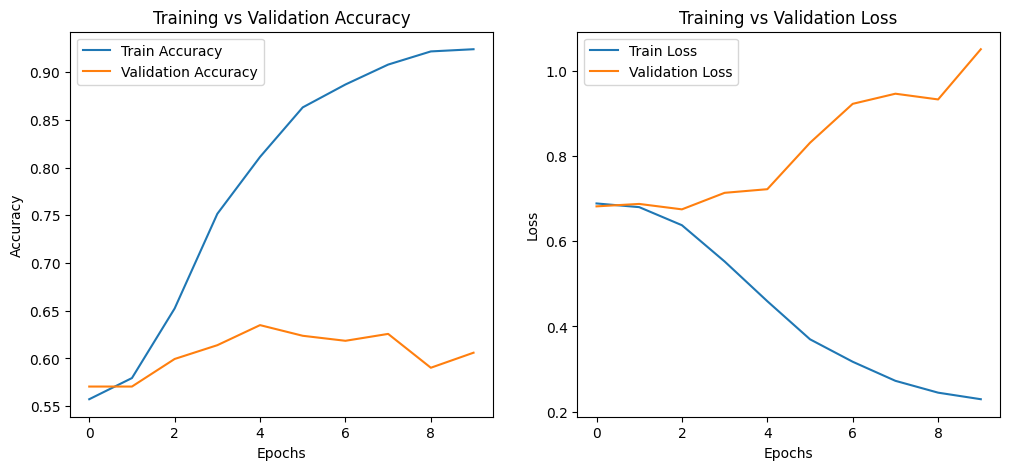

In [135]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()

Note: Simple RNN yeild Accuracy at 0.6060 and F1 Score at 0.5455. I have analysis the graph - it seems that the model is overfiting and not genelize enogh. So, we can apply dropout to improve it.

In [136]:
# Load output file to drive
y_test_pred = (rnn_model.predict(X_test) > 0.5).astype("int32")
result = pd.DataFrame({"id": test["id"], "target": y_test_pred.flatten()})
result.to_csv("/content/my_submission.csv", index=False)

result.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,1


In [137]:
from google.colab import files
files.download("/content/my_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Try BiLSTM Model

In [138]:
# Define hyparameters
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

In [139]:
# BiLSTM model
bilstm_model = Sequential([
    Embedding(input_dim=MAX_WORDS+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [140]:
dummy_input = np.zeros((1, MAX_SEQUENCE_LENGTH))
bilstm_model.predict(dummy_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.5042559]], dtype=float32)

In [141]:
# Compile model
bilstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [142]:
# Display model summary
bilstm_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (1, 100, 100)               │       1,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_8                  │ (1, 100, 100)               │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (1, 100, 128)               │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (1, 64)                     │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,127,909 (4.30 MB)

 Trainable params: 1,127,909 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

In [143]:
history_bilstm = bilstm_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6114 - loss: 0.6455 - val_accuracy: 0.8050 - val_loss: 0.4350
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8625 - loss: 0.3493 - val_accuracy: 0.8017 - val_loss: 0.4530
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9185 - loss: 0.2296 - val_accuracy: 0.7978 - val_loss: 0.4932
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9465 - loss: 0.1660 - val_accuracy: 0.7840 - val_loss: 0.5485
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9591 - loss: 0.1235 - val_accuracy: 0.7761 - val_loss: 0.6409
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9680 - loss: 0.0948 - val_accuracy: 0.7708 - val_loss: 0.7424
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9738 - loss: 0.0743 - val_accuracy: 0.7525 - val_loss: 0.7640
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9718 - loss: 0.0735 - val_ac

In [144]:
# Predict on validation set
y_val_pred_bilstm = (bilstm_model.predict(X_val) > 0.5).astype("int32")

# Compute accuracy and F1-score
val_accuracy_bilstm = accuracy_score(y_val, y_val_pred_bilstm)
val_f1_score_bilstm = f1_score(y_val, y_val_pred_bilstm)

print(f"BiLSTM Accuracy: {val_accuracy_bilstm:.4f}")
print(f"BiLSTM F1 Score: {val_f1_score_bilstm:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
BiLSTM Accuracy: 0.7656
BiLSTM F1 Score: 0.7200


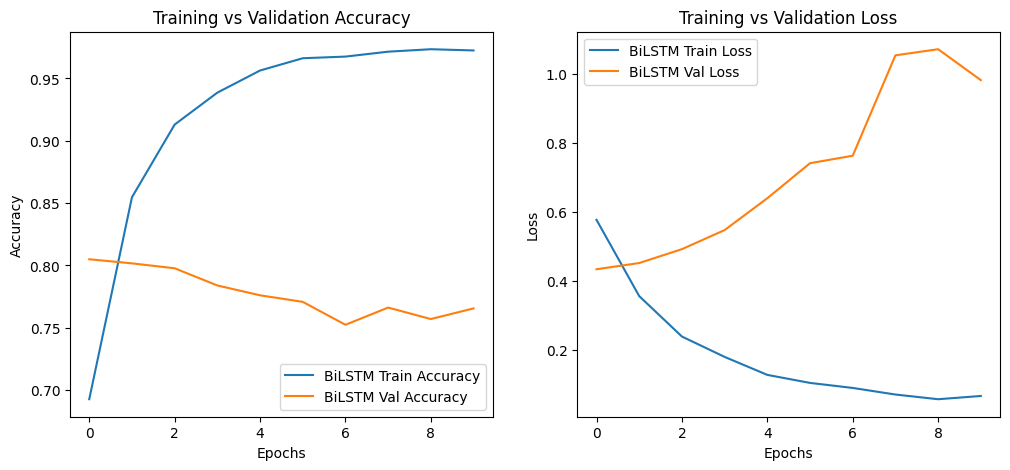

In [145]:
# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_bilstm.history["accuracy"], label="BiLSTM Train Accuracy")
plt.plot(history_bilstm.history["val_accuracy"], label="BiLSTM Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot loss
plt.subplot(1,2,2)
plt.plot(history_bilstm.history["loss"], label="BiLSTM Train Loss")
plt.plot(history_bilstm.history["val_loss"], label="BiLSTM Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()

In [146]:
# Predict on test dataset
y_test_pred_bilstm = (bilstm_model.predict(X_test) > 0.5).astype("int32")
result = pd.DataFrame({"id": test["id"], "target": y_test_pred_bilstm.flatten()})
result.to_csv("/content/my_submission.csv", index=False)

files.download("/content/my_submission.csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4. Results and Analysis

**The Simple RNN model:**

The model achieved an accuracy of 0.6060 and an F1 score of 0.5455. However, the model overfits, meaning it performs well on training data but struggles with new data. This is clear from the accuracy gap between training and validation. To fix this, we can add more dropout or use a stronger model like LSTM or GRU.

**The BiLSTM model:**
It performed better, with a validation accuracy of 0.7656 and an F1 score of 0.7200. However, the validation loss keeps increasing, which still suggests overfitting. The training accuracy reaches 98%, while validation accuracy stays around 76-77%, meaning the model memorizes training data but does not generalize well.

Here is my ideas to improve the model;
- Increase dropout to reduce overfitting.
- Apply early stopping when validation loss rises.
- Play around with hyperparameters like learning rate and batch size.

## 5. Conclusion

The BiLSTM model outperformed Simple RNN, achieving 0.7656 accuracy and 0.7200 F1 score, but still showed overfitting as validation loss increased. Dropout and BiLSTM helped improve performance, but training embeddings from scratch and a complex model size led to overfitting.

To improve, we can use pre-trained embeddings (GloVe), apply early stopping, reduce model complexity, and fine-tune hyperparameters. Future work could explore GRU or Transformer-based models for better generalization.